In [1]:
# Stdlib
import os
from pathlib import Path
from datetime import datetime, timedelta, timezone, date
from zoneinfo import ZoneInfo

# Third-party
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import norm
from dotenv import load_dotenv, find_dotenv
from polygon import RESTClient
# === PATCH A: streaming imports & live NBBO cache ===
import os, json, threading, time
from collections import deque
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import numpy as np
import pandas as pd

# Real-time NBBO cache for options quotes
LIVE_NBBO = {}  # { "O:XYZ...": {"bid": float, "ask": float, "ts": datetime_utc} }
LIVE_NBBO_LOCK = threading.Lock()
FRESHNESS_SECS = 15  # only use quotes newer than this many seconds


In [14]:
# =============================================================================
# eSSVI Fit — Polygon SPX options (vendor IV) + Yahoo Finance spot (^GSPC)
# Uses "previous filter" convention: strike filter = [0.95, 1.05] * S_ref
# where S_ref is Polygon snapshot price for I:SPX if available, else Yahoo (^GSPC).
# k = ln(K / S_yahoo). No WebSocket, no parity. Fits eSSVI to vendor IVs.
# Requirements: polygon-api-client>=1.15, yfinance, scipy, pandas, numpy
# Optional: python-dotenv to load POLYGON_API_KEY from .env
# =============================================================================

# --- Imports -----------------------------------------------------------------
import os
from datetime import datetime, timezone, timedelta, date

import numpy as np
import pandas as pd

try:
    from dotenv import load_dotenv, find_dotenv
    _ = load_dotenv(find_dotenv())
except Exception:
    pass

# Polygon REST
try:
    from polygon import RESTClient
except Exception as e:
    raise RuntimeError(
        "Missing Polygon client. Install with: pip install -U polygon-api-client"
    ) from e

# Yahoo Finance spot
try:
    import yfinance as yf
except Exception as e:
    raise RuntimeError("Missing yfinance. Install with: pip install -U yfinance") from e

from scipy.optimize import minimize

# --- Config ------------------------------------------------------------------
POLYGON_API_KEY = os.getenv("POLYGON_API_KEY")
assert POLYGON_API_KEY and len(POLYGON_API_KEY) > 5, "Set POLYGON_API_KEY in env or .env"

UNDERLYING_TICKER = "I:SPX"   # SPX index options on Polygon
YAHOO_SYMBOL      = "^GSPC"   # S&P 500 index spot from Yahoo
ASOF_UTC          = datetime.now(timezone.utc)
ASOF_DATE         = ASOF_UTC.date()

# Tenor/chain window & selection
DTE_MIN, DTE_MAX  = 7, 60           # fit 1–4 weeks by default
IV_MIN, IV_MAX    = 0.01, 3.00
K_ABS_CAP         = 0.50            # tighter wings help stability
MIN_POINTS        = 20              # minimum points per expiry to keep

# --- 1) Fetch Yahoo spot (S) for ^GSPC --------------------------------------
def get_yahoo_spot(symbol="^GSPC"):
    tkr = yf.Ticker(symbol)
    price = None
    ts = None

    # Try fast_info
    try:
        fi = getattr(tkr, "fast_info", None)
        if fi:
            price = fi.get("last_price")
    except Exception:
        pass

    # Fallback to recent 1m bar
    if price is None:
        try:
            hist = tkr.history(period="1d", interval="1m")
            if hist is not None and len(hist) > 0:
                last = hist.tail(1)
                price = float(last["Close"].iloc[0])
                ts = last.index[-1].to_pydatetime().replace(tzinfo=timezone.utc)
        except Exception:
            pass

    # Final fallback to 1d bar
    if price is None:
        try:
            hist = tkr.history(period="5d", interval="1d")
            if hist is not None and len(hist) > 0:
                last = hist.tail(1)
                price = float(last["Close"].iloc[0])
                ts = last.index[-1].to_pydatetime().replace(tzinfo=timezone.utc)
        except Exception:
            pass

    if price is None or not np.isfinite(price) or price <= 0:
        raise RuntimeError("Could not fetch Yahoo spot for ^GSPC.")

    if ts is None:
        ts = ASOF_UTC
    return float(price), ts

S_yahoo, S_timestamp = get_yahoo_spot(YAHOO_SYMBOL)
print(f"Yahoo spot (^GSPC): {S_yahoo:.4f} @ {S_timestamp.isoformat()}")

# --- 1b) Try Polygon snapshot for I:SPX to use as S_ref for strike filter ----
def get_polygon_underlying_price(client: RESTClient, ticker: str):
    """
    Try to get a reasonable underlying print from Polygon snapshot for the index.
    Return (price, source_str). If unavailable, return (nan, 'unavailable').
    """
    try:
        snap = client.get_snapshot(ticker)
        price = None

        # Try last trade price fields that may exist depending on model version
        lt = getattr(snap, "last_trade", None)
        if lt is not None:
            price = getattr(lt, "p", None) or getattr(lt, "price", None)

        # Fallback to minute close
        if price is None:
            m = getattr(snap, "minute", None)
            if m is not None:
                price = getattr(m, "c", None) or getattr(m, "close", None)

        if price is not None and np.isfinite(price) and float(price) > 0:
            return float(price), "polygon_snapshot"
    except Exception:
        pass
    return float("nan"), "unavailable"

client = RESTClient(POLYGON_API_KEY)
S_poly, poly_src = get_polygon_underlying_price(client, UNDERLYING_TICKER)

# Choose S_ref for strike filtering: Polygon snapshot (if valid) else Yahoo
if np.isfinite(S_poly) and S_poly > 0:
    S_ref = S_poly
    S_ref_source = "polygon_snapshot"
else:
    S_ref = S_yahoo
    S_ref_source = "yahoo_fallback"

print(f"S_ref for strike filter: {S_ref:.4f} (source: {S_ref_source})")

# --- 2) Fetch SPX options chain from Polygon (vendor IV) ---------------------
beginning_date = (ASOF_DATE + timedelta(days=DTE_MIN)).isoformat()
end_date       = (ASOF_DATE + timedelta(days=DTE_MAX)).isoformat()

params = {
    "order": "asc",
    "limit": 100,
    "sort": "ticker",
    "expiration_date.gte": beginning_date,
    "expiration_date.lte": end_date,
}

# >>> Apply the "previous filter" convention here:
if np.isfinite(S_ref):
    params["strike_price.gte"] = S_ref * 0.95
    params["strike_price.lte"] = S_ref * 1.05

options_chain = list(client.list_snapshot_options_chain(UNDERLYING_TICKER, params=params))
print(f"Pulled {len(options_chain)} SPX option snapshots (Polygon).")

# Normalize → DataFrame
records = []
for o in options_chain:
    det = getattr(o, "details", None)
    gr  = getattr(o, "greeks",  None)
    rec = {
        "ticker":          getattr(det, "ticker", None),
        "contract_type":   (getattr(det, "contract_type", None) or "").lower(),
        "expiration_date": getattr(det, "expiration_date", None),
        "strike_price":    getattr(det, "strike_price", None),
        "iv_vendor":       getattr(o,   "implied_volatility", None),  # <-- vendor IV
        "vega_vendor":     getattr(gr,  "vega", None),
        "open_interest":   getattr(o,   "open_interest", None),
    }
    records.append(rec)

df = pd.DataFrame(records)
if df.empty:
    raise RuntimeError("Empty chain returned. Check plan access / symbols / window.")

df["expiration_date"] = pd.to_datetime(df["expiration_date"], errors="coerce").dt.date
df["strike_price"]    = pd.to_numeric(df["strike_price"], errors="coerce")
df["iv_vendor"]       = pd.to_numeric(df["iv_vendor"], errors="coerce")
df["vega_vendor"]     = pd.to_numeric(df["vega_vendor"], errors="coerce")
df["open_interest"]   = pd.to_numeric(df["open_interest"], errors="coerce").fillna(0.0)

df = df.dropna(subset=["expiration_date","strike_price","contract_type","iv_vendor"]).copy()
df = df[df["iv_vendor"].between(IV_MIN, IV_MAX)]
df = df[df["strike_price"] > 0]

# --- 3) Build targets using vendor IV and Yahoo S -----------------------------
def yearfrac(d0: date, d1: date) -> float:
    return (pd.to_datetime(d1).date() - pd.to_datetime(d0).date()).days / 365.0

df["T"] = df["expiration_date"].apply(lambda e: max(yearfrac(ASOF_DATE, e), 0.0))
df = df[df["T"] > 0]  # forward-looking expiries only

# moneyness with Yahoo spot (model choice remains the same)
df["k"] = np.log(df["strike_price"].astype(float) / float(S_yahoo))

# trims
keep = np.abs(df["k"]) <= K_ABS_CAP
df = df[keep].copy()

# require a minimum #points per expiry
per_expiry_counts = df.groupby("expiration_date")["k"].size()
valid_expiries = per_expiry_counts[per_expiry_counts >= MIN_POINTS].index
df = df[df["expiration_date"].isin(valid_expiries)].copy()

if df.empty:
    raise RuntimeError("No targets after filters; consider relaxing the strike filter (e.g., 0.9–1.1) or K_ABS_CAP.")

# Prepare final targets
targets = df.rename(columns={"expiration_date":"expiry", "iv_vendor":"iv"})
targets = targets[["expiry","T","k","iv","strike_price","vega_vendor","open_interest"]].reset_index(drop=True)

# Quick summaries
per_expiry_summary = (
    targets.groupby("expiry")
           .agg(n_points=("k","size"), T=("T","first"),
                k_min=("k","min"), k_max=("k","max"),
                iv_med=("iv","median"))
           .reset_index()
           .sort_values("expiry")
)
print("\nTargets summary (first 10 expiries):")
print(per_expiry_summary.head(10))
print(f"\nTotal targets rows: {len(targets)}")

# --- 4) eSSVI fit on vendor IV -----------------------------------------------
expiries = np.array(sorted(targets["expiry"].unique()))
T_map = {e: float(targets.loc[targets["expiry"]==e, "T"].iloc[0]) for e in expiries}
T_vec = np.array([T_map[e] for e in expiries], dtype=float)

# theta initial from ATM vendor IV: theta = iv^2 * T
theta_vec = []
for e in expiries:
    sub = targets[targets["expiry"]==e]
    near = sub.loc[np.abs(sub["k"])<=0.03, "iv"]
    if len(near) >= 3:
        th = float(np.median(near)**2 * float(sub["T"].iloc[0]))
    else:
        j  = int(np.abs(sub["k"]).idxmin())
        th = float(sub.loc[j, "iv"]**2 * sub.loc[j, "T"])
    theta_vec.append(max(th, 1e-6))
theta_vec = np.maximum.accumulate(np.array(theta_vec, dtype=float))

# pack arrays
exp_idx = targets["expiry"].map({e:i for i,e in enumerate(expiries)}).to_numpy()
k_i  = targets["k"].to_numpy(float)
iv_i = targets["iv"].to_numpy(float)
T_i  = targets["T"].to_numpy(float)

# Weights: vendor vega (proxy), proximity to ATM, and liquidity
vega_proxy = pd.to_numeric(targets["vega_vendor"], errors="coerce").fillna(0.0).to_numpy(float)
prox       = 1.0 / (1.0 + np.abs(k_i))
liq        = (pd.to_numeric(targets["open_interest"], errors="coerce").fillna(0.0).clip(0) + 1.0) ** 0.25
wt_i       = np.maximum(vega_proxy, 1.0) * prox * liq
wt_i       = wt_i.astype(float)

def essvi_w(theta, rho, psi, k):
    x = psi*k + rho
    return 0.5*theta*(1.0 + rho*psi*k + np.sqrt(x*x + 1.0 - rho*rho))

def unpack_params(z):
    n = len(theta_vec)
    r_raw = z[:n]
    u_raw = z[n:]
    rho = np.tanh(r_raw)
    u   = 1.0/(1.0 + np.exp(-u_raw))
    # enforce the Gatheral–Jacquier bound softly
    psi_limit = 4.0/(theta_vec*(1.0 + np.abs(rho))) * 0.99
    psi = u * psi_limit
    return rho, psi

lam_r = 1e-2
lam_u = 1e-2

def objective(z):
    rho, psi = unpack_params(z)
    th_rows = theta_vec[exp_idx]
    rh_rows = rho[exp_idx]
    ps_rows = psi[exp_idx]
    w_model = essvi_w(th_rows, rh_rows, ps_rows, k_i)
    iv_model = np.sqrt(np.maximum(w_model, 0.0) / np.maximum(T_i, 1e-12))
    iv_resid = iv_model - iv_i
    ls_loss = np.sum(wt_i * (iv_resid**2))
    # smoothness along expiry dimension
    r_diff = np.diff(np.arctanh(np.clip(rho, -0.999, 0.999)))
    u_diff = np.diff(z[len(theta_vec):])
    reg = lam_r*np.sum(r_diff**2) + lam_u*np.sum(u_diff**2)
    return ls_loss + reg

# optimize
n = len(theta_vec)
r0 = np.full(n, -0.5, dtype=float)
u0 = np.full(n,  0.5, dtype=float)
z0 = np.concatenate([r0, np.log(u0/(1-u0))])

res = minimize(objective, z0, method="L-BFGS-B", options={"maxiter": 300, "ftol": 1e-9})
if not res.success:
    print("WARNING: optimizer terminated with message:", res.message)

rho_fit, psi_fit = unpack_params(res.x)
phi_fit = psi_fit / np.sqrt(theta_vec)

params_table = pd.DataFrame({
    "expiry": expiries,
    "T": T_vec,
    "theta": theta_vec,
    "rho": rho_fit,
    "psi": psi_fit,
    "phi": phi_fit
}).sort_values("expiry").reset_index(drop=True)

print("\nFitted eSSVI parameters (first 10):")
print(params_table.head(10))

# Diagnostics
th_rows = theta_vec[exp_idx]
rh_rows= rho_fit[exp_idx]
ps_rows= psi_fit[exp_idx]
w_hat = essvi_w(th_rows, rh_rows, ps_rows, k_i)
wmse  = np.average((w_hat - (iv_i**2)*T_i)**2, weights=wt_i)
mae_iv_bp = np.mean(np.abs(np.sqrt(np.maximum(w_hat,1e-12)/np.maximum(T_i,1e-12)) - iv_i)) * 10000.0

print(f"\nYahoo S (^GSPC): {S_yahoo:.4f}")
print(f"S_ref used for strike filter: {S_ref:.4f} (source: {S_ref_source})")
print(f"Weighted MSE in w: {wmse:.6e}")
print(f"Mean abs IV error ≈ {mae_iv_bp:.1f} bp")


Yahoo spot (^GSPC): 6606.5698 @ 2025-09-15T13:19:00+00:00
S_ref for strike filter: 6606.5698 (source: yahoo_fallback)
Pulled 4184 SPX option snapshots (Polygon).

Targets summary (first 10 expiries):
       expiry  n_points         T     k_min     k_max    iv_med
0  2025-09-22       202  0.019178 -0.050695  0.047073  0.132899
1  2025-09-23       202  0.021918 -0.050695  0.047073  0.131131
2  2025-09-24       203  0.024658 -0.050695  0.047073  0.131174
3  2025-09-25       197  0.027397 -0.050695  0.047073  0.129426
4  2025-09-26       229  0.030137 -0.050695  0.047795  0.125826
5  2025-09-29       172  0.038356 -0.050695  0.047073  0.125420
6  2025-09-30       226  0.041096 -0.050695  0.047795  0.121621
7  2025-10-01       168  0.043836 -0.050695  0.047073  0.127622
8  2025-10-02       160  0.046575 -0.050695  0.047073  0.127379
9  2025-10-03       218  0.049315 -0.050695  0.047073  0.126802

Total targets rows: 4163

Fitted eSSVI parameters (first 10):
       expiry         T     theta

Saved: plots\theta_vs_T_20250915_132003.png
Saved: plots\rho_vs_T_20250915_132003.png
Saved: plots\psi_vs_T_20250915_132003.png
Saved: plots\phi_vs_T_20250915_132003.png
Saved: plots\model_vs_vendor_iv_20250915_132003.png
Saved: plots\residual_hist_bp_20250915_132003.png


C:\Users\husey\AppData\Local\Temp\ipykernel_23052\1459095740.py:64: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



Saved: plots\mae_by_expiry_bp_20250915_132003.png

Overall MAE ≈ 36.9 bp across 4163 points and 26 expiries.


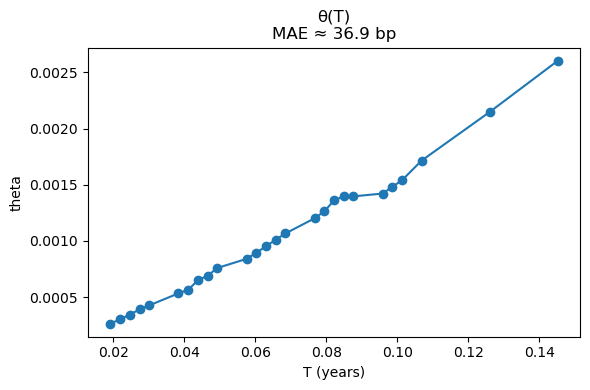

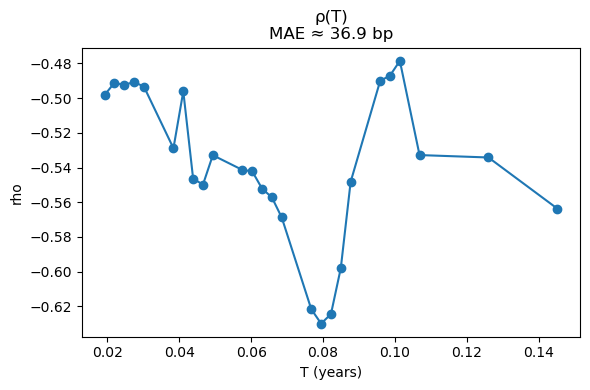

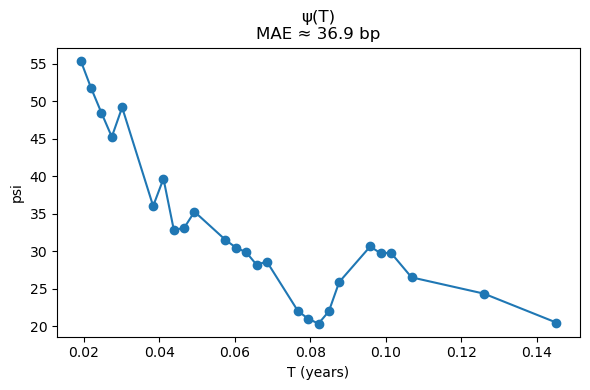

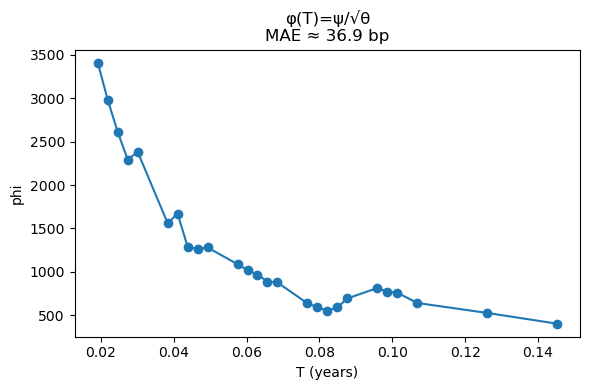

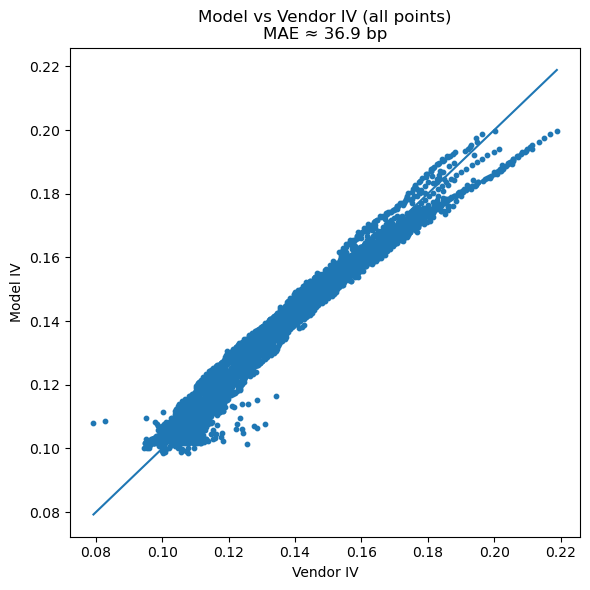

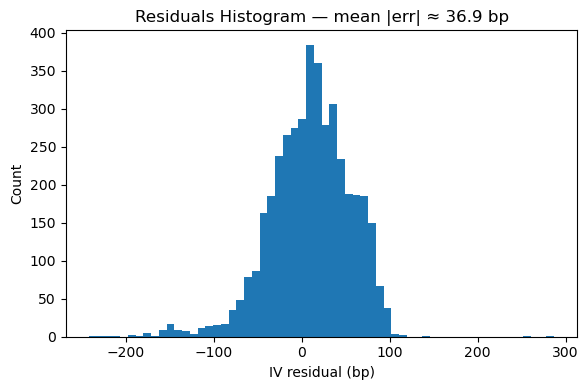

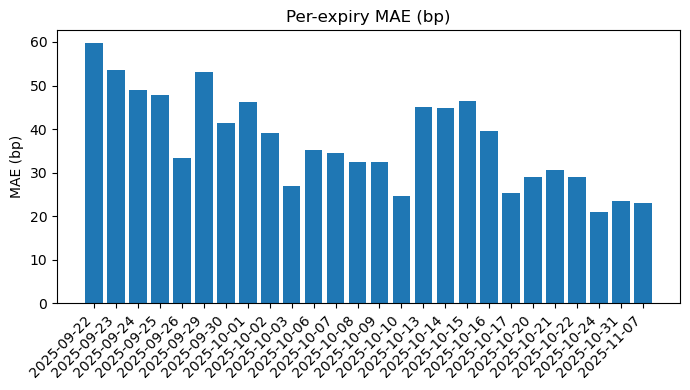

In [16]:
# ===============================
# Plots & diagnostics (saved PNG)
# ===============================
import matplotlib.pyplot as plt
from pathlib import Path

plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

def _savefig(fig, name):
    fp = plots_dir / f"{name}_{ts}.png"
    fig.tight_layout()
    fig.savefig(fp, dpi=180)
    print(f"Saved: {fp}")

# Reuse model IV + residuals
iv_mod = np.sqrt(np.maximum(w_hat, 1e-12) / np.maximum(T_i, 1e-12))
err_iv = iv_mod - iv_i
err_bp = err_iv * 10000.0

# ---- Parameter curves vs T ----
def _line_plot(x, y, xlabel, ylabel, title, name, marker='o'):
    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(x, y, marker=marker)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title}\nMAE ≈ {mae_iv_bp:.1f} bp")
    _savefig(fig, name)

_line_plot(T_vec, theta_vec, "T (years)", "theta", "θ(T)", "theta_vs_T")
_line_plot(T_vec, rho_fit,   "T (years)", "rho",   "ρ(T)", "rho_vs_T")
_line_plot(T_vec, psi_fit,   "T (years)", "psi",   "ψ(T)", "psi_vs_T")
_line_plot(T_vec, phi_fit,   "T (years)", "phi",   "φ(T)=ψ/√θ", "phi_vs_T")

# ---- Model vs Vendor IV scatter ----
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(iv_i, iv_mod, s=10)
lo, hi = float(min(iv_i.min(), iv_mod.min())), float(max(iv_i.max(), iv_mod.max()))
ax.plot([lo, hi], [lo, hi])
ax.set_xlabel("Vendor IV")
ax.set_ylabel("Model IV")
ax.set_title(f"Model vs Vendor IV (all points)\nMAE ≈ {mae_iv_bp:.1f} bp")
_savefig(fig, "model_vs_vendor_iv")

# ---- Residual histogram (bp) ----
fig, ax = plt.subplots(figsize=(6,4))
ax.hist(err_bp, bins=60)
ax.set_xlabel("IV residual (bp)")
ax.set_ylabel("Count")
ax.set_title(f"Residuals Histogram — mean |err| ≈ {mae_iv_bp:.1f} bp")
_savefig(fig, "residual_hist_bp")

# ---- Per-expiry MAE (bp) ----
mae_by_expiry = (
    pd.DataFrame({"expiry": targets["expiry"], "abs_err_bp": np.abs(err_bp)})
      .groupby("expiry")["abs_err_bp"]
      .mean()
      .reset_index()
      .sort_values("expiry")
)
fig, ax = plt.subplots(figsize=(7,4))
ax.bar(mae_by_expiry["expiry"].astype(str), mae_by_expiry["abs_err_bp"])
ax.set_xticklabels(mae_by_expiry["expiry"].astype(str), rotation=45, ha="right")
ax.set_ylabel("MAE (bp)")
ax.set_title("Per-expiry MAE (bp)")
_savefig(fig, "mae_by_expiry_bp")

print(f"\nOverall MAE ≈ {mae_iv_bp:.1f} bp across {len(iv_i)} points and {len(T_vec)} expiries.")


In [18]:
# --- OPTIONAL: Interactive Plotly surface (IV ↔ w toggle) --------------------
try:
    import plotly.graph_objects as go

    # Ensure total variance exists for scatter
    if "w" not in targets.columns:
        targets = targets.copy()
        targets["w"] = (targets["iv"].astype(float) ** 2) * targets["T"].astype(float)

    # k-range from data (padded)
    k_min = float(targets["k"].quantile(0.01))
    k_max = float(targets["k"].quantile(0.99))
    pad   = 0.05 * (k_max - k_min)
    k_min, k_max = k_min - pad, k_max + pad

    # Grid
    K = np.linspace(k_min, k_max, 121)
    T = np.linspace(float(T_vec.min()), float(T_vec.max()), 60)
    KK, TT = np.meshgrid(K, T)

    # Interpolate term-structure parameters on the T grid
    theta_T = np.interp(T, T_vec, theta_vec)
    rho_T   = np.interp(T, T_vec, rho_fit)
    psi_T   = np.interp(T, T_vec, psi_fit)

    TH = theta_T[:, None]
    RH = rho_T[:, None]
    PS = psi_T[:, None]

    # eSSVI formulas
    W  = 0.5 * TH * (1.0 + RH * PS * KK + np.sqrt((PS * KK + RH)**2 + 1.0 - RH**2))
    IV = np.sqrt(np.maximum(W, 0.0) / np.maximum(T[:, None], 1e-12))

    # ATM ridge
    W_atm  = 0.5 * theta_T
    IV_atm = np.sqrt(np.maximum(W_atm, 0.0) / np.maximum(T, 1e-12))

    # Subsample market points for clarity
    show = targets.sample(min(len(targets), 4000), random_state=7).copy()

    surf_iv = go.Surface(
        x=K, y=T, z=IV, name="eSSVI IV",
        hovertemplate="k=%{x:.3f}<br>T=%{y:.3f}y<br>IV=%{z:.4f}<extra></extra>",
        showscale=True, colorbar=dict(title="IV"), visible=True
    )
    surf_w  = go.Surface(
        x=K, y=T, z=W, name="eSSVI w",
        hovertemplate="k=%{x:.3f}<br>T=%{y:.3f}y<br>w=%{z:.5f}<extra></extra>",
        showscale=True, colorbar=dict(title="w"), visible=False
    )
    scat_iv = go.Scatter3d(
        x=show["k"], y=show["T"], z=show["iv"],
        mode="markers", name="market IV",
        marker=dict(size=2, opacity=0.55),
        hovertemplate="k=%{x:.3f}<br>T=%{y:.3f}y<br>IV=%{z:.4f}<extra></extra>",
        visible=True
    )
    scat_w  = go.Scatter3d(
        x=show["k"], y=show["T"], z=show["w"],
        mode="markers", name="market w",
        marker=dict(size=2, opacity=0.55),
        hovertemplate="k=%{x:.3f}<br>T=%{y:.3f}y<br>w=%{z:.5f}<extra></extra>",
        visible=False
    )
    atm_iv  = go.Scatter3d(
        x=np.zeros_like(T), y=T, z=IV_atm, mode="lines",
        name="ATM ridge (IV)", line=dict(width=6),
        hovertemplate="k=0<br>T=%{y:.3f}y<br>IV=%{z:.4f}<extra></extra>", visible=True
    )
    atm_w   = go.Scatter3d(
        x=np.zeros_like(T), y=T, z=W_atm, mode="lines",
        name="ATM ridge (w)", line=dict(width=6),
        hovertemplate="k=0<br>T=%{y:.3f}y<br>w=%{z:.5f}<extra></extra>", visible=False
    )

    fig = go.Figure(data=[surf_iv, surf_w, scat_iv, scat_w, atm_iv, atm_w])
    fig.update_layout(
        title="eSSVI Surface (interactive)",
        scene=dict(
            xaxis_title="log-moneyness  k",
            yaxis_title="T (years)",
            zaxis_title="IV",
            camera=dict(eye=dict(x=1.6, y=1.4, z=0.9))
        ),
        margin=dict(l=10, r=10, t=60, b=10),
        width=1200, height=750,
        updatemenus=[dict(
            type="buttons", direction="right", x=0.5, y=1.12, xanchor="center",
            buttons=[
                dict(
                    label="Show IV", method="update",
                    args=[{"visible":[True, False, True, False, True, False]},
                          {"scene":{"zaxis":{"title":"IV"}}}]
                ),
                dict(
                    label="Show w (total variance)", method="update",
                    args=[{"visible":[False, True, False, True, False, True]},
                          {"scene":{"zaxis":{"title":"w"}}}]
                ),
            ]
        )]
    )
    fig.show()
except Exception as e:
    print("[Plotly] Interactive surface skipped:", e)



In [20]:
# ---- Save interactive HTML (+ optional PNG thumbnail) ----
from pathlib import Path
import plotly.io as pio
from copy import deepcopy

plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1) Save interactive (single file HTML, JS via CDN to keep file small)
html_path = plots_dir / f"eSSVI_surface_{ts}.html"
fig.write_html(str(html_path), include_plotlyjs="cdn", full_html=True)
print(f"[Plotly] Saved interactive HTML → {html_path}")

# 2) Save a static PNG of the IV view (requires `pip install -U kaleido`)
try:
    fig_iv = deepcopy(fig)
    # Make the IV set visible: [surf_iv, surf_w, scat_iv, scat_w, atm_iv, atm_w]
    for i, vis in enumerate([True, False, True, False, True, False]):
        fig_iv.data[i].visible = vis
    png_path = plots_dir / f"eSSVI_surface_IV_{ts}.png"
    pio.write_image(fig_iv, str(png_path), width=1200, height=750, scale=2)
    print(f"[Plotly] Saved PNG → {png_path}")
except Exception as e:
    print("[Plotly] PNG skipped (install 'kaleido'):", e)


[Plotly] Saved interactive HTML → plots\eSSVI_surface_20250915_132310.html
[Plotly] Saved PNG → plots\eSSVI_surface_IV_20250915_132310.png


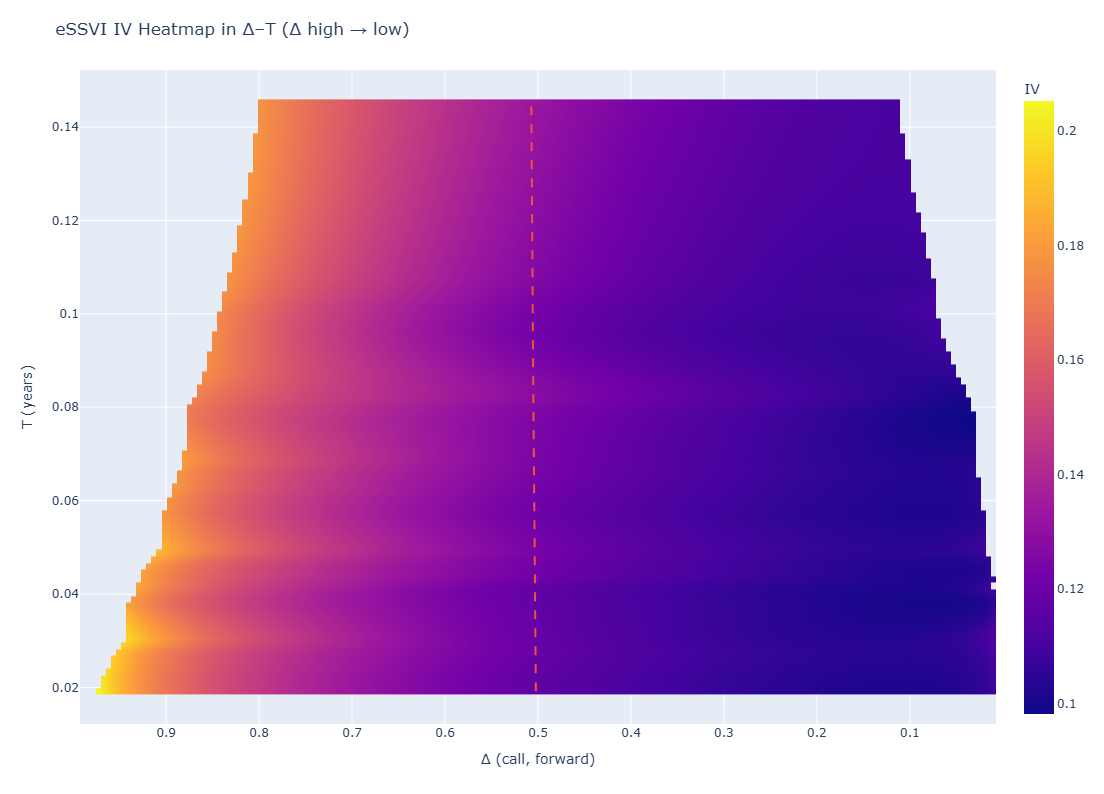

RR/BF table (first 12 rows):
     T_years    ATM_IV    IV_25C    IV_25P      RR25      BF25
0   0.019178  0.082839  0.104635  0.139745 -0.035110  0.039351
1   0.020594  0.082838  0.104759  0.139631 -0.034871  0.039356
2   0.022010  0.082862  0.104920  0.139487 -0.034567  0.039341
3   0.023426  0.083204  0.105316  0.140115 -0.034799  0.039512
4   0.024842  0.083527  0.105716  0.140621 -0.034905  0.039641
5   0.026258  0.083955  0.106300  0.141243 -0.034943  0.039816
6   0.027674  0.084240  0.106606  0.141953 -0.035347  0.040040
7   0.029090  0.084114  0.105917  0.143722 -0.037805  0.040705
8   0.030506  0.083988  0.105363  0.144878 -0.039515  0.041132
9   0.031922  0.083843  0.105123  0.144010 -0.038886  0.040723
10  0.033338  0.083710  0.104935  0.143081 -0.038146  0.040299
11  0.034755  0.083587  0.104807  0.142100 -0.037293  0.039866


In [22]:
# ===============================
# Δ–T heatmap (reversed x) + RR/BF table
# ===============================
import numpy as np
from scipy.stats import norm
import plotly.graph_objects as go
import pandas as pd

# --- helpers from your fit ---
def _interp_params(Tq):
    Tq = np.asarray(Tq, float)
    th = np.interp(Tq, T_vec, theta_vec)
    rh = np.interp(Tq, T_vec, rho_fit)
    ps = np.interp(Tq, T_vec, psi_fit)
    return th, rh, ps

def model_w_Tk(Tq, kq):
    Tq = np.atleast_1d(np.asarray(Tq, float))
    kq = np.atleast_1d(np.asarray(kq, float))
    th, rh, ps = _interp_params(Tq)
    w  = essvi_w(th[:, None], rh[:, None], ps[:, None], kq[None, :])
    return np.maximum(w, 1e-12)

# --- k–T grid -> IV & Δ ---
k_min = float(targets["k"].quantile(0.01))
k_max = float(targets["k"].quantile(0.99))
pad   = 0.05 * (k_max - k_min)
k_min, k_max = k_min - pad, k_max + pad

K  = np.linspace(k_min, k_max, 161)
T  = np.linspace(float(T_vec.min()), float(T_vec.max()), 90)
KK, TT = np.meshgrid(K, T)

W  = model_w_Tk(T, K)
IV = np.sqrt(W / np.maximum(TT, 1e-12))

# call-forward delta
D1_grid    = (-KK + 0.5*W) / np.sqrt(W)
DELTA_grid = norm.cdf(D1_grid)              # (0,1)

# --- map IV to uniform Δ grid per T-row (for table & plotting) ---
DEL    = np.linspace(0.01, 0.99, 181)       # Δ axis
IV_DEL = np.full((len(T), len(DEL)), np.nan)

for i in range(len(T)):
    d = DELTA_grid[i]
    iv= IV[i]
    o = np.argsort(d)
    d = d[o]; iv = iv[o]
    keep = np.r_[True, np.diff(d) > 1e-10]  # unique Δ
    d = d[keep]; iv = iv[keep]
    if d.size >= 2:
        lo, hi = float(d[0]), float(d[-1])
        m = (DEL >= lo) & (DEL <= hi)
        IV_DEL[i, m] = np.interp(DEL[m], d, iv)

# --- ATM Δ curve (for overlay) ---
theta_T = np.interp(T, T_vec, theta_vec)
w_atm   = 0.5 * theta_T
ATM_DEL = norm.cdf(0.5*np.sqrt(np.maximum(w_atm, 1e-12)))
ATM_IV  = np.sqrt(w_atm / np.maximum(T, 1e-12))

# --- heatmap with reversed Δ axis ---
hm = go.Heatmap(
    x=DEL, y=T, z=IV_DEL, colorbar=dict(title="IV"),
    zsmooth="best",
    hovertemplate="Δ=%{x:.3f}<br>T=%{y:.3f}y<br>IV=%{z:.4f}<extra></extra>"
)
atm_line = go.Scatter(
    x=ATM_DEL, y=T, mode="lines", name="ATM (Δ)",
    line=dict(width=2, dash="dash")
)
fig = go.Figure([hm, atm_line])
fig.update_layout(
    title="eSSVI IV Heatmap in Δ–T (Δ high → low)",
    xaxis_title="Δ (call, forward)", yaxis_title="T (years)",
    width=1200, height=780, margin=dict(l=80, r=40, t=70, b=70)
)
fig.update_xaxes(autorange="reversed")  # <<< reverse Δ (high→low)
fig.show()

# ================
# RR/BF 25Δ table
# ================
def _nearest_col(xgrid, x):
    return int(np.nanargmin(np.abs(xgrid - x)))

j_25C = _nearest_col(DEL, 0.25)  # 25Δ call
j_25P = _nearest_col(DEL, 0.75)  # 25Δ put (abs-delta -> call-delta 0.75)

sigma_25C = IV_DEL[:, j_25C]     # may contain NaNs if Δ not covered
sigma_25P = IV_DEL[:, j_25P]
sigma_ATM = ATM_IV

RR25 = sigma_25C - sigma_25P
BF25 = 0.5*(sigma_25C + sigma_25P) - sigma_ATM

rrbf_table = pd.DataFrame({
    "T_years": T,
    "ATM_IV": sigma_ATM,
    "IV_25C": sigma_25C,
    "IV_25P": sigma_25P,
    "RR25": RR25,
    "BF25": BF25,
}).dropna().reset_index(drop=True)

print("RR/BF table (first 12 rows):")
print(rrbf_table.head(12).round(6))

# Optional: quick lines
# import plotly.express as px
# px.line(rrbf_table, x="T_years", y=["RR25","BF25","ATM_IV"],
#         title="25Δ RR / BF and ATM vs T", labels={"T_years":"T (years)", "value":"Vol"}).show()


In [24]:
# ---- Save heatmap + RR/BF outputs ----
from pathlib import Path
import plotly.io as pio
from copy import deepcopy

plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1) Save the Δ–T heatmap (interactive HTML + static PNG if 'kaleido' is installed)
heatmap_html = plots_dir / f"iv_heatmap_delta_T_{ts}.html"
fig.write_html(str(heatmap_html), include_plotlyjs="cdn", full_html=True)
print(f"[Plotly] Saved heatmap HTML → {heatmap_html}")

try:
    heatmap_png = plots_dir / f"iv_heatmap_delta_T_{ts}.png"
    pio.write_image(fig, str(heatmap_png), width=1200, height=780, scale=2)
    print(f"[Plotly] Saved heatmap PNG → {heatmap_png}")
except Exception as e:
    print("[Plotly] PNG skipped (install 'kaleido'):", e)

# 2) Save RR/BF table to CSV (and nice Markdown)
rrbf_csv = plots_dir / f"rrbf_25d_table_{ts}.csv"
rrbf_md  = plots_dir / f"rrbf_25d_table_{ts}.md"
rrbf_table.to_csv(rrbf_csv, index=False)
with open(rrbf_md, "w", encoding="utf-8") as f:
    f.write(rrbf_table.round(6).to_markdown(index=False))
print(f"[Table] Saved RR/BF CSV → {rrbf_csv}")
print(f"[Table] Saved RR/BF Markdown → {rrbf_md}")

# 3) Optional: RR/BF/ATM vs T line chart (HTML + optional PNG)
fig_rrbf = go.Figure()
fig_rrbf.add_scatter(x=rrbf_table["T_years"], y=rrbf_table["RR25"], name="RR25")
fig_rrbf.add_scatter(x=rrbf_table["T_years"], y=rrbf_table["BF25"], name="BF25")
fig_rrbf.add_scatter(x=rrbf_table["T_years"], y=rrbf_table["ATM_IV"], name="ATM IV")
fig_rrbf.update_layout(
    title="25Δ RR / BF and ATM vs T",
    xaxis_title="T (years)", yaxis_title="Vol", width=900, height=500, margin=dict(l=60,r=40,t=60,b=60)
)
rrbf_html = plots_dir / f"rrbf_lines_{ts}.html"
fig_rrbf.write_html(str(rrbf_html), include_plotlyjs="cdn", full_html=True)
print(f"[Plotly] Saved RR/BF lines HTML → {rrbf_html}")

try:
    rrbf_png = plots_dir / f"rrbf_lines_{ts}.png"
    pio.write_image(fig_rrbf, str(rrbf_png), width=900, height=500, scale=2)
    print(f"[Plotly] Saved RR/BF lines PNG → {rrbf_png}")
except Exception as e:
    print("[Plotly] RR/BF PNG skipped (install 'kaleido'):", e)


[Plotly] Saved heatmap HTML → plots\iv_heatmap_delta_T_20250915_132515.html
[Plotly] Saved heatmap PNG → plots\iv_heatmap_delta_T_20250915_132515.png
[Table] Saved RR/BF CSV → plots\rrbf_25d_table_20250915_132515.csv
[Table] Saved RR/BF Markdown → plots\rrbf_25d_table_20250915_132515.md
[Plotly] Saved RR/BF lines HTML → plots\rrbf_lines_20250915_132515.html
[Plotly] Saved RR/BF lines PNG → plots\rrbf_lines_20250915_132515.png


In [5]:
# Convert IV levels to percent and RR/BF to basis points (bp)
rrbf_bp = rrbf_table.copy()

rrbf_bp["ATM_IV_%"] = rrbf_bp["ATM_IV"] * 100.0
rrbf_bp["IV_25C_%"] = rrbf_bp["IV_25C"] * 100.0
rrbf_bp["IV_25P_%"] = rrbf_bp["IV_25P"] * 100.0

rrbf_bp["RR25_bp"]  = rrbf_bp["RR25"]  * 10000.0    # 1 bp = 0.0001
rrbf_bp["BF25_bp"]  = rrbf_bp["BF25"]  * 10000.0

# Keep tidy columns & round for display
rrbf_bp = (
    rrbf_bp[["T_years","ATM_IV_%","IV_25C_%","IV_25P_%","RR25_bp","BF25_bp"]]
      .round({"T_years": 4, "ATM_IV_%": 2, "IV_25C_%": 2, "IV_25P_%": 2, "RR25_bp": 1, "BF25_bp": 1})
)

print("RR/BF table (IV in %, spreads in bp):")
print(rrbf_bp.head(12).to_string(index=False))

# (Optional) quick plot in bp
# import plotly.express as px
# px.line(rrbf_bp, x="T_years", y=["RR25_bp","BF25_bp"],
#         title="25Δ RR/BF vs T (bp)", labels={"T_years":"T (years)","value":"bp"}).show()


RR/BF table (IV in %, spreads in bp):
 T_years  ATM_IV_%  IV_25C_%  IV_25P_%  RR25_bp  BF25_bp
  0.0192      8.08     10.17     13.68   -350.5    384.6
  0.0206      8.12     10.24     13.71   -346.8    385.5
  0.0220      8.15     10.30     13.72   -341.5    385.9
  0.0234      8.19     10.36     13.78   -341.8    387.6
  0.0248      8.23     10.42     13.83   -340.9    389.0
  0.0263      8.28     10.49     13.89   -340.3    391.1
  0.0277      8.32     10.54     13.97   -343.3    393.5
  0.0291      8.31     10.48     14.14   -366.6    399.5
  0.0305      8.31     10.43     14.26   -382.8    403.2
  0.0319      8.30     10.41     14.18   -376.6    399.0
  0.0333      8.30     10.40     14.09   -368.9    394.7
  0.0348      8.29     10.40     13.99   -359.7    390.2


In [6]:
# ============================
# Δ–T → IV 3D surface (Plotly)
# ============================

# --- 1) Interpolate (θ, ρ, ψ) over T
def _interp_params(Tq):
    Tq = np.asarray(Tq, float)
    th = np.interp(Tq, T_vec, theta_vec)
    rh = np.interp(Tq, T_vec, rho_fit)
    ps = np.interp(Tq, T_vec, psi_fit)
    return th, rh, ps

def model_w_Tk(Tq, kq):
    Tq = np.atleast_1d(np.asarray(Tq, float))
    kq = np.atleast_1d(np.asarray(kq, float))
    th, rh, ps = _interp_params(Tq)
    w  = essvi_w(th[:, None], rh[:, None], ps[:, None], kq[None, :])
    return np.maximum(w, 1e-12)

# --- 2) Build a k–T grid, compute w and IV
# k-range from data (pad a bit)
k_min = float(targets["k"].quantile(0.01))
k_max = float(targets["k"].quantile(0.99))
pad   = 0.05 * (k_max - k_min)
k_min, k_max = k_min - pad, k_max + pad

K = np.linspace(k_min, k_max, 141)                           # log-moneyness grid
T = np.linspace(float(T_vec.min()), float(T_vec.max()), 80)  # time grid (years)
KK, TT = np.meshgrid(K, T)

W  = model_w_Tk(T, K)                                        # total variance on grid
IV = np.sqrt(W / np.maximum(TT, 1e-12))                      # Black vol

# --- 3) Map to call forward delta: Δ = Φ(d1), d1 = (-k + 0.5 w)/sqrt(w)
D1_grid     = (-KK + 0.5*W) / np.sqrt(W)
DELTA_grid  = norm.cdf(D1_grid)                              # in (0,1)

# --- 4) Plotly 3D surface: x=Δ, y=T, z=IV
surf = go.Surface(
    x=DELTA_grid, y=TT, z=IV, name="eSSVI IV(Δ,T)",
    hovertemplate="Δ=%{x:.3f}<br>T=%{y:.3f}y<br>IV=%{z:.4f}<extra></extra>",
    showscale=True, colorbar=dict(title="IV")
)

fig = go.Figure(data=[surf])
fig.update_layout(
    title="eSSVI IV Surface in Δ–T space",
    scene=dict(
        xaxis_title="Δ (call, forward)",
        yaxis_title="T (years)",
        zaxis_title="IV",
        camera=dict(eye=dict(x=1.6, y=1.4, z=0.9))
    ),
    width=1200, height=750, margin=dict(l=10, r=10, t=60, b=10)
)
fig = go.Figure(data=[surf])
fig.update_layout(
    title="eSSVI IV Surface in Δ–T space",
    scene=dict(
        xaxis=dict(title="Δ (call, forward)", autorange="reversed"),  # ← flip X
        yaxis=dict(title="T (years)"),
        zaxis=dict(title="IV"),
        camera=dict(eye=dict(x=1.6, y=1.4, z=0.9))
    ),
    width=1200, height=750, margin=dict(l=10, r=10, t=60, b=10)
)
fig.show()



In [26]:
# ---- Save Δ–T IV surface (interactive HTML + optional PNG) ----
from pathlib import Path
import plotly.io as pio

plots_dir = Path("plots")
plots_dir.mkdir(exist_ok=True)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")

html_path = plots_dir / f"iv_surface_delta_T_{ts}.html"
fig.write_html(str(html_path), include_plotlyjs="cdn", full_html=True)
print(f"[Plotly] Saved surface HTML → {html_path}")

# Static PNG (requires: pip install -U kaleido)
try:
    png_path = plots_dir / f"iv_surface_delta_T_{ts}.png"
    pio.write_image(fig, str(png_path), width=1200, height=750, scale=2)
    print(f"[Plotly] Saved surface PNG → {png_path}")
except Exception as e:
    print("[Plotly] PNG skipped (install 'kaleido'):", e)


[Plotly] Saved surface HTML → plots\iv_surface_delta_T_20250915_132958.html
[Plotly] Saved surface PNG → plots\iv_surface_delta_T_20250915_132958.png
